Skipping category 'Complaint' due to insufficient data for quarterly forecasting. (Need at least 9 data points, found 3)
Skipping category 'Request For Change' due to insufficient data for quarterly forecasting. (Need at least 9 data points, found 1)

✅ Processed 2 categories with enough data for quarterly forecasting.


--- Future Forecasting for Category: 'Incident' (Quarterly) ---
Historical data points: 9
Last historical date: 2024-01-01
Future forecast period: 2024-04-01 to 2025-01-01

🔮 Future Forecasted Ticket Volumes (Rounded to nearest integer):
ARIMA Forecast for 2024-04-01 to 2025-01-01:
  2024-04-01: 18331
  2024-07-01: 19050
  2024-10-01: 36830
  2025-01-01: 36530
Random Forest Forecast for 2024-04-01 to 2025-01-01:
  2024-04-01: 12270
  2024-07-01: 11754
  2024-10-01: 16640
  2025-01-01: 13356


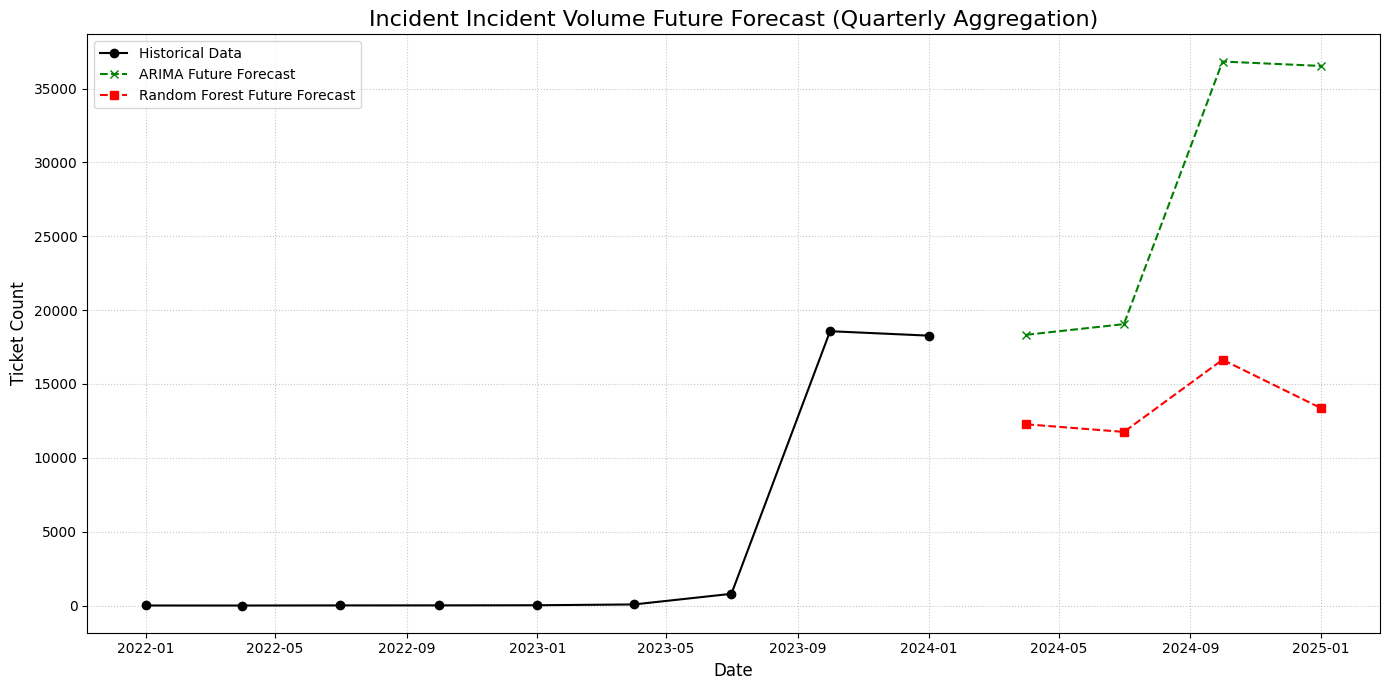


--- Future Forecasting for Category: 'Request For Information' (Quarterly) ---
Historical data points: 9
Last historical date: 2024-01-01
Future forecast period: 2024-04-01 to 2025-01-01

🔮 Future Forecasted Ticket Volumes (Rounded to nearest integer):
ARIMA Forecast for 2024-04-01 to 2025-01-01:
  2024-04-01: 4015
  2024-07-01: 4157
  2024-10-01: 8846
  2025-01-01: 7644
Random Forest Forecast for 2024-04-01 to 2025-01-01:
  2024-04-01: 2485
  2024-07-01: 2502
  2024-10-01: 4018
  2025-01-01: 2706


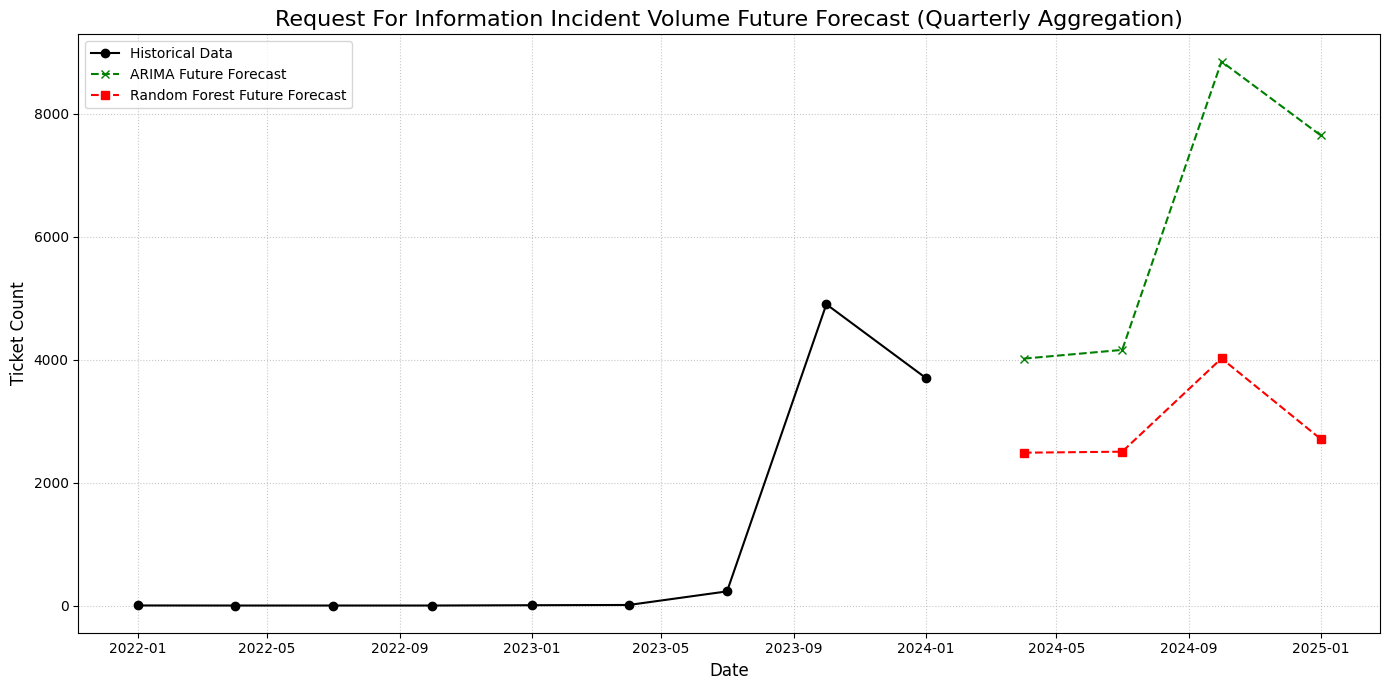

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX # Using SARIMAX for both seasonal and non-seasonal ARIMA
from sklearn.ensemble import RandomForestRegressor
from dateutil.relativedelta import relativedelta # Import for advanced date calculations
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

# --- Configuration ---
# Set the desired time aggregation granularity for forecasting.
# Options: 'quarterly' or 'annually'.
TIME_GRANULARITY = 'quarterly' # Change this to 'annually' to predict annual volumes

# Determine forecast horizon and model parameters based on selected granularity.
if TIME_GRANULARITY == 'quarterly':
    FORECAST_HORIZON = 4 # Predict next 4 quarters (one year ahead)
    SARIMA_SEASONAL_ORDER = (1, 1, 1, 4) # Seasonal period of 4 for quarterly data
    RF_FEATURES = ['year', 'quarter'] # Features for Random Forest: year and quarter
    DATE_FREQ = 'QS' # Quarter Start frequency for pandas date_range
elif TIME_GRANULARITY == 'annually':
    FORECAST_HORIZON = 1 # Predict next 1 year
    SARIMA_SEASONAL_ORDER = (0, 0, 0, 0) # No seasonal component for annual data
    RF_FEATURES = ['year'] # Features for Random Forest: only year
    DATE_FREQ = 'AS' # Year Start frequency for pandas date_range
else:
    # Raise an error if an unsupported granularity is chosen.
    raise ValueError("TIME_GRANULARITY must be 'quarterly' or 'annually'.")


# --- Load Data ---
file_path = "ITSM_data.csv"
try:
    # Load the dataset. 'Open_Time' is used for incident volume as it signifies when the incident occurred.
    # 'dayfirst=True' is crucial for correct date parsing. 'low_memory=False' prevents mixed type warnings.
    df = pd.read_csv(file_path, parse_dates=['Open_Time'], dayfirst=True, low_memory=False)
except FileNotFoundError:
    # Handle the case where the CSV file is not found.
    print(f"Error: The file '{file_path}' was not found. Please ensure it's in the same directory.")
    exit() # Exit the script if the file is missing.

# --- Data Cleaning ---
# Select only the 'Open_Time' and 'Category' columns, which are necessary for this analysis.
df = df[['Open_Time', 'Category']].copy()
# Remove rows that have missing values in 'Open_Time' or 'Category'.
df.dropna(subset=['Open_Time', 'Category'], inplace=True)
# Clean the 'Category' column:
# 1. Convert to string type.
# 2. Remove leading/trailing whitespace.
# 3. Convert to title case (e.g., 'incident' becomes 'Incident').
# 4. Replace any empty strings (which might result from cleaning) with 'Unknown'.
df['Category'] = df['Category'].astype(str).str.strip().str.title().replace('', 'Unknown')
# Convert 'Open_Time' to datetime objects, coercing any parsing errors to NaT (Not a Time).
df['Open_Time'] = pd.to_datetime(df['Open_Time'], errors='coerce')
# Remove rows where 'Open_Time' could not be parsed and resulted in NaT.
df.dropna(subset=['Open_Time'], inplace=True)
# Create a 'Date' column from 'Open_Time' for initial daily aggregation.
df['Date'] = df['Open_Time'].dt.date

# Aggregate ticket count by date and category. This gives daily ticket counts per category.
daily_counts = df.groupby(['Date', 'Category']).size().reset_index(name='Ticket_Count')

# --- Preprocess and Resample Data Based on Granularity ---
def preprocess_data(df_daily_counts, time_granularity):
    """
    Aggregates daily ticket counts to the specified time granularity (quarterly or annually).

    Args:
        df_daily_counts (pd.DataFrame): DataFrame with daily ticket counts.
        time_granularity (str): 'quarterly' or 'annually'.

    Returns:
        dict: A dictionary where keys are categories and values are DataFrames
              with aggregated ticket counts ('ds' for date, 'y' for ticket count).
              Only includes categories with sufficient data for forecasting.
    """
    processed_data = {}
    # Iterate through each unique category in the daily counts.
    for category in df_daily_counts['Category'].unique():
        # Filter the DataFrame for the current category.
        cat_df = df_daily_counts[df_daily_counts['Category'] == category].copy()
        # Convert 'Date' column to datetime objects and set it as the DataFrame index.
        cat_df['Date'] = pd.to_datetime(cat_df['Date'])
        cat_df.set_index('Date', inplace=True)

        # Determine the resampling rule based on the chosen time granularity.
        if time_granularity == 'quarterly':
            rule = 'QS' # Quarter Start frequency
        elif time_granularity == 'annually':
            rule = 'AS' # Year Start frequency
        else:
            # This should ideally not be reached due to the initial check, but included for robustness.
            raise ValueError("Invalid time_granularity. Must be 'quarterly' or 'annually'.")

        # Resample the 'Ticket_Count' column using the determined rule and sum the counts.
        agg_df = cat_df['Ticket_Count'].resample(rule).sum().reset_index()
        # Rename columns to 'ds' (date stamp) and 'y' (target variable) for consistency.
        agg_df.rename(columns={'Date': 'ds', 'Ticket_Count': 'y'}, inplace=True)

        # Ensure enough data points for training and forecasting.
        # A minimum number of data points is required for reliable model training.
        # For seasonal SARIMA, we need at least 2 full seasonal cycles + forecast horizon.
        min_data_points = max(FORECAST_HORIZON + 1, 2 * SARIMA_SEASONAL_ORDER[3] + 1 if SARIMA_SEASONAL_ORDER[3] > 0 else 5)

        if len(agg_df) >= min_data_points:
            processed_data[category] = agg_df
        else:
            # Inform the user if a category is skipped due to insufficient data.
            print(f"Skipping category '{category}' due to insufficient data for {time_granularity} forecasting. "
                  f"(Need at least {min_data_points} data points, found {len(agg_df)})")
    return processed_data

# --- Metrics (for potential backtesting/evaluation on historical data) ---
def evaluate_model(y_true, y_pred):
    """
    Calculates Mean Absolute Error (MAE), Root Mean Squared Error (RMSE),
    and Mean Absolute Percentage Error (MAPE) for model evaluation.

    Args:
        y_true (pd.Series): Actual values.
        y_pred (pd.Series or np.ndarray): Predicted values.

    Returns:
        dict: A dictionary containing MAE, RMSE, and MAPE.
    """
    # Ensure y_pred is a Series aligned with y_true's index for proper evaluation.
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Drop NaNs from both true and predicted values to ensure valid comparisons.
    common_index = y_true.dropna().index.intersection(y_pred.dropna().index)
    y_true_eval = y_true.loc[common_index]
    y_pred_eval = y_pred.loc[common_index]

    if len(y_true_eval) == 0:
        # Return NaN metrics if there's no common data for evaluation.
        return {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

    # Calculate MAE and RMSE.
    mae = mean_absolute_error(y_true_eval, y_pred_eval)
    rmse = np.sqrt(mean_squared_error(y_true_eval, y_pred_eval))
    
    # Calculate MAPE, handling potential division by zero by replacing zeros in y_true_eval with NaN.
    y_true_non_zero = np.where(y_true_eval != 0, y_true_eval, np.nan)
    mape = np.nanmean(np.abs((y_true_eval - y_pred_eval) / y_true_non_zero)) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# --- ARIMA Model ---
def train_and_forecast_arima(history_df, future_df, seasonal_order):
    """
    Trains a SARIMAX model on historical data and generates forecasts for future periods.

    Args:
        history_df (pd.DataFrame): Historical data with 'ds' and 'y' columns.
        future_df (pd.DataFrame): DataFrame with 'ds' column for future periods to forecast.
        seasonal_order (tuple): SARIMA seasonal order (P, D, Q, S).

    Returns:
        pd.Series: Forecasted values for the future periods.
    """
    try:
        history_series = history_df.set_index('ds')['y']
        # Initialize SARIMAX model. 'enforce_stationarity' and 'enforce_invertibility'
        # are set to False for robustness with certain time series data.
        model = SARIMAX(history_series, order=(1, 1, 1), seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        # Fit the model, suppressing detailed output during fitting.
        model_fit = model.fit(disp=False)
        
        # Generate forecast for the length of the future periods.
        # The 'start' and 'end' parameters define the range for the forecast.
        forecast = model_fit.predict(start=future_df['ds'].min(), end=future_df['ds'].max())
        
        # Ensure the forecast index matches the future_df dates.
        forecast.index = future_df['ds']
        
        return forecast
    except Exception as e:
        # Print error details if ARIMA model fitting or forecasting fails.
        print(f"ARIMA error during future forecasting for {future_df['ds'].min().strftime('%Y-%m-%d')} to {future_df['ds'].max().strftime('%Y-%m-%d')}: {e}")
        # Return NaN series if an error occurs.
        return pd.Series([np.nan]*len(future_df), index=future_df['ds'])

# --- Time features for Random Forest ---
def create_time_features(df, features_list):
    """
    Creates time-based features for the Random Forest Regressor.

    Args:
        df (pd.DataFrame): DataFrame with a 'ds' (datetime) column.
        features_list (list): List of feature names to create (e.g., ['year', 'quarter']).

    Returns:
        pd.DataFrame: DataFrame with added time features.
    """
    df_copy = df.copy()
    df_copy['year'] = df_copy['ds'].dt.year # Extract year.
    if 'quarter' in features_list:
        df_copy['quarter'] = df_copy['ds'].dt.quarter # Extract quarter if specified.
    # Month, dayofyear, and weekofyear are omitted as they are less relevant for
    # quarterly/annual aggregated data and could potentially lead to overfitting.
    return df_copy

# --- Random Forest model ---
def train_and_forecast_rf(history_df, future_df, features_list):
    """
    Trains a RandomForestRegressor model on historical data and generates forecasts for future periods.

    Args:
        history_df (pd.DataFrame): Historical data with 'ds' and 'y' columns.
        future_df (pd.DataFrame): DataFrame with 'ds' column for future periods to forecast.
        features_list (list): List of feature names to use for training and prediction.

    Returns:
        pd.Series: Forecasted values for the future periods.
    """
    try:
        # Create time features for the historical data (training).
        train_feat = create_time_features(history_df.copy(), features_list)
        # Create time features for the future periods (prediction).
        future_feat = create_time_features(future_df.copy(), features_list)
        
        # Filter the features to ensure only existing columns are used.
        actual_features = [f for f in features_list if f in train_feat.columns]
        
        if not actual_features:
            # Raise an error if no valid features can be created for the model.
            raise ValueError("No valid features for Random Forest model after creation.")

        # Initialize and train the RandomForestRegressor.
        model = RandomForestRegressor(n_estimators=100, random_state=42) # 100 trees, fixed random state for reproducibility.
        model.fit(train_feat[actual_features], train_feat['y'])
        
        # Generate predictions for the future periods.
        pred = model.predict(future_feat[actual_features])
        
        # Return predictions as a Series with aligned dates.
        return pd.Series(pred, index=future_df['ds'])
    except Exception as e:
        # Print error details if Random Forest model training or forecasting fails.
        print(f"RF error during future forecasting for {future_df['ds'].min().strftime('%Y-%m-%d')} to {future_df['ds'].max().strftime('%Y-%m-%d')}: {e}")
        # Return NaN series if an error occurs.
        return pd.Series([np.nan]*len(future_df), index=future_df['ds'])

# --- Plot results ---
def plot_forecasts(history_df, future_df, arima_pred, rf_pred, category, time_granularity):
    """
    Plots the actual historical data and forecasts from ARIMA and Random Forest models
    for future periods.

    Args:
        history_df (pd.DataFrame): Historical data.
        future_df (pd.DataFrame): DataFrame with future dates.
        arima_pred (pd.Series): ARIMA model's predictions for future.
        rf_pred (pd.Series): Random Forest model's predictions for future.
        category (str): The category for which the forecast is made.
        time_granularity (str): The time aggregation granularity ('quarterly' or 'annually').
    """
    plt.figure(figsize=(14, 7)) # Set a larger figure size for better readability.
    
    # Plot historical data.
    plt.plot(history_df['ds'], history_df['y'], label='Historical Data', color='black', marker='o', linestyle='-')
    
    # Plot ARIMA forecast for future periods.
    plt.plot(future_df['ds'], arima_pred, label='ARIMA Future Forecast', linestyle='--', color='green', marker='x')
    # Plot Random Forest forecast for future periods.
    plt.plot(future_df['ds'], rf_pred, label='Random Forest Future Forecast', linestyle='--', color='red', marker='s')
    
    # Set plot title and labels.
    plt.title(f"{category} Incident Volume Future Forecast ({time_granularity.title()} Aggregation)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Ticket Count", fontsize=12)
    plt.legend(fontsize=10) # Display legend to identify lines.
    plt.grid(True, linestyle=':', alpha=0.7) # Add a subtle grid.
    plt.tight_layout() # Adjust layout to prevent labels from overlapping.
    
    # Save the plot with a dynamic filename based on category and granularity.
    plot_filename = f"{category.lower().replace(' ', '_')}_{time_granularity}_future_forecast.png"
    plt.savefig(plot_filename)
    plt.show()

# --- Run Pipeline ---
# Process the daily aggregated ticket counts into the desired time granularity.
processed = preprocess_data(daily_counts, time_granularity=TIME_GRANULARITY)
print(f"\n✅ Processed {len(processed)} categories with enough data for {TIME_GRANULARITY} forecasting.\n")

if not processed:
    # If no categories have sufficient data, inform the user.
    print("❌ No valid data available for forecasting for the selected granularity.")
else:
    # Iterate through each category that has sufficient data and perform forecasting.
    for category, df_agg in processed.items():
        # The entire aggregated data is now considered historical data for training.
        history_df = df_agg.copy()

        # Determine the start date for the future forecast.
        # It's one period after the last historical data point.
        if TIME_GRANULARITY == 'quarterly':
            last_history_date = history_df['ds'].max()
            future_start_date = last_history_date + relativedelta(months=3)
        elif TIME_GRANULARITY == 'annually':
            last_history_date = history_df['ds'].max()
            future_start_date = last_history_date + relativedelta(years=1)
        
        # Create a DataFrame for the future periods to forecast.
        future_dates = pd.date_range(start=future_start_date, periods=FORECAST_HORIZON, freq=DATE_FREQ)
        future_df = pd.DataFrame({'ds': future_dates})


        print(f"\n--- Future Forecasting for Category: '{category}' ({TIME_GRANULARITY.title()}) ---")
        print(f"Historical data points: {len(history_df)}")
        print(f"Last historical date: {history_df['ds'].max().strftime('%Y-%m-%d')}")
        print(f"Future forecast period: {future_df['ds'].min().strftime('%Y-%m-%d')} to {future_df['ds'].max().strftime('%Y-%m-%d')}")

        # Train and forecast using the ARIMA (SARIMAX) model for future periods.
        arima_future_pred = train_and_forecast_arima(history_df, future_df, SARIMA_SEASONAL_ORDER)
        
        # Train and forecast using the Random Forest Regressor model for future periods.
        rf_future_pred = train_and_forecast_rf(history_df, future_df, RF_FEATURES)

        print("\n🔮 Future Forecasted Ticket Volumes (Rounded to nearest integer):")
        # Print ARIMA forecasts if available.
        if not arima_future_pred.isnull().all():
            print(f"ARIMA Forecast for {future_df['ds'].min().strftime('%Y-%m-%d')} to {future_df['ds'].max().strftime('%Y-%m-%d')}:")
            for date, val in arima_future_pred.round(0).astype(int).items():
                print(f"  {date.strftime('%Y-%m-%d')}: {val}")
        else:
            print("ARIMA Future Forecast: Not available (model error)")

        # Print Random Forest forecasts if available.
        if not rf_future_pred.isnull().all():
            print(f"Random Forest Forecast for {future_df['ds'].min().strftime('%Y-%m-%d')} to {future_df['ds'].max().strftime('%Y-%m-%d')}:")
            for date, val in rf_future_pred.round(0).astype(int).items():
                print(f"  {date.strftime('%Y-%m-%d')}: {val}")
        else:
            print("Random Forest Future Forecast: Not available (model error)")

        # Plot the future forecasts for the current category.
        plot_forecasts(history_df, future_df, arima_future_pred, rf_future_pred, category, TIME_GRANULARITY)
